[Solution 2](https://colab.research.google.com/drive/1p8U798dCxC1aElkVtE2oO5-UQ8VYhvtA?usp=sharing)

#Install packages

In [ ]:
!pip install torch torchvision
!pip install numpy
!pip install pandas
!pip install d2l==1.0.3
!pip install google.colab
!pip install nltk

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/core.py", line 4114, in parseImpl
    return e._parse(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/core.py", line 821, in _parseNoCache
    loc, tokens = self.parseImpl(instring, pre_loc, doActions)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/core.py", line 2341, in parseImpl
    raise ParseException(instring, loc, self.errmsg, self)
pip._vendor.pyparsing.exceptions.ParseException: Expected 'sys.platform',

#Imports

In [1]:
import pandas as pd
import io
import os
import math
import torch
from collections import Counter
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torch import nn
from d2l import torch as d2l
from google.colab import files
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Optimizer
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize

if not os.path.exists('train.csv'):
  uploaded = files.upload()

Saving dev.csv to dev.csv
Saving train.csv to train.csv


#Load data

In [2]:
df = pd.read_csv('train.csv')
val = pd.read_csv('dev.csv')

In [5]:
#Checks if glove embeddings are already loaded
if not os.path.exists('glove.6B.zip'):
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove.6B.zip -d glove.6B

def load_glove_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

glove_path = 'glove.6B/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

In [6]:
nltk.download('punkt')  #Downloads the punkt tokenizer models

def simple_tokenize(text):
    return word_tokenize(text.lower())  #Tokenizes and converts to lower case

#This function converts text into a fixed-length array of embeddings
def text_to_embeddings(text, embeddings_dict, max_length):
    tokens = word_tokenize(text.lower())
    #Fetch embeddings or zero vectors for each token
    embeddings = [embeddings_dict.get(token, np.zeros(100)) for token in tokens[:max_length]]

    #Ensure all embeddings have the same length by padding with zeros if necessary
    if len(embeddings) < max_length:
        # Pad with zero vectors of the same dimension as the embeddings
        embeddings.extend([np.zeros(100) for _ in range(max_length - len(embeddings))])

    #Convert list of embeddings to a single NumPy array ensuring it's float32 for compatibility with PyTorch
    return np.vstack(embeddings).astype(np.float32)

#Custom class that extends PyTorch’s Dataset class.
#It is designed to handle loading and transforming text data for a model
class TextDataset(Dataset):
    def __init__(self, embeddings_dict, df, max_length=256):
        self.embeddings_dict = embeddings_dict
        self.claims = df['Claim'].tolist()
        self.evidences = df['Evidence'].tolist()
        self.labels = df['label'].tolist()
        self.max_length = max_length

    def __len__(self):
        return len(self.claims)

    #Retrieves the combined claim and its evidence converts this text to an embedding tensor. Needed for dataLoader
    def __getitem__(self, idx):
        text = self.claims[idx] + " " + self.evidences[idx]
        embeddings = text_to_embeddings(text, self.embeddings_dict, self.max_length)
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return embeddings_tensor, label

train_dataset = TextDataset(glove_embeddings, df, max_length=256)
val_dataset = TextDataset(glove_embeddings, val, max_length=256)

#Dataloader instances manage the batching of data and can shuffle the data for the training dataset.
#This helps efficiently manage memory and speeds up the training process by using processing capabilities of PyTorch.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Encoder

In [7]:
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        #Transformer encoder model, based on d2l.
        #Consist of multi-headed attention layer, add norm, positionwise FFN and another add norm.
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = d2l.AddNorm(num_hiddens, dropout)
        self.ffn = d2l.PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = d2l.AddNorm(num_hiddens, dropout)

    def forward(self, X):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens = None))
        return self.addnorm2(Y, self.ffn(Y))

In [8]:
class TransformerEncoder(d2l.Encoder):
    """The Transformer encoder."""
    def __init__(self, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X):
        #Positional encoding is applied to the GloVe embedded words once, before passing it into the encoder blocks.
        #Here we have 2 blocks
        X = self.pos_encoding(X * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

#Classification

In [9]:
class ClassificationHead(nn.Module):
    """A simple classification head with a single linear layer."""
    def __init__(self, num_hiddens, num_classes):
        super().__init__()
        self.linear = nn.Linear(num_hiddens, num_classes)

    def forward(self, X):
        #Classification layer, produces output of 1 or 0.
        return self.linear(X[:, 0, :])

#ED Model

In [10]:
class EvidenceDetectionModel(nn.Module):
    """This class combines the transformer encoder with the classification head."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, num_classes=2, use_bias=False):
        super().__init__()
        #Full combined model, with data being passed through encoder before the final classification layer.
        self.encoder = TransformerEncoder(num_hiddens, ffn_num_hiddens,
                                          num_heads, num_blks, dropout, use_bias)
        self.classifier = ClassificationHead(num_hiddens, num_classes)

    def forward(self, X):
        encoded_X = self.encoder(X)
        classification_logits = self.classifier(encoded_X)
        return classification_logits

#Training

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

#Function to compute metrics
def compute_metrics(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')
    return accuracy, precision, recall, f1

#Function to evaluate the model
def evaluate_predictions(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for embeddings, labels in data_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            logits = model(embeddings)
            predictions = torch.argmax(logits, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return compute_metrics(all_predictions, all_labels)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 1/15, Train Loss: 0.5162, Val Loss: 0.4735
Model saved for epoch 1
Epoch 2/15, Train Loss: 0.4678, Val Loss: 0.4362
Model saved for epoch 2
Epoch 3/15, Train Loss: 0.4497, Val Loss: 0.4649
Model saved for epoch 3
Epoch 4/15, Train Loss: 0.4417, Val Loss: 0.4645
Model saved for epoch 4
Epoch 5/15, Train Loss: 0.4354, Val Loss: 0.4394
Model saved for epoch 5
Epoch 6/15, Train Loss: 0.4282, Val Loss: 0.4214
Model saved for epoch 6
Epoch 7/15, Train Loss: 0.4260, Val Loss: 0.4265
Model saved for epoch 7
Epoch 8/15, Train Loss: 0.4230, Val Loss: 0.4161
Model saved for epoch 8
Epoch 9/15, Train Loss: 0.4178, Val Loss: 0.4223
Model saved for epoch 9
Epoch 10/15, Train Loss: 0.4141, Val Loss: 0.4423
Model saved for epoch 10
Epoch 11/15, Train Loss: 0.4103, Val Loss: 0.4153
Model saved for epoch 11
Epoch 12/15, Train Loss: 0.4075, Val Loss: 0.4907
Model saved for epoch 12
Epoch 13/15, Train Loss: 0.4098, Val Loss: 0.4519
Model saved for epoch 13
Epoch 14/15, Train Loss: 0.4079, Val Loss: 

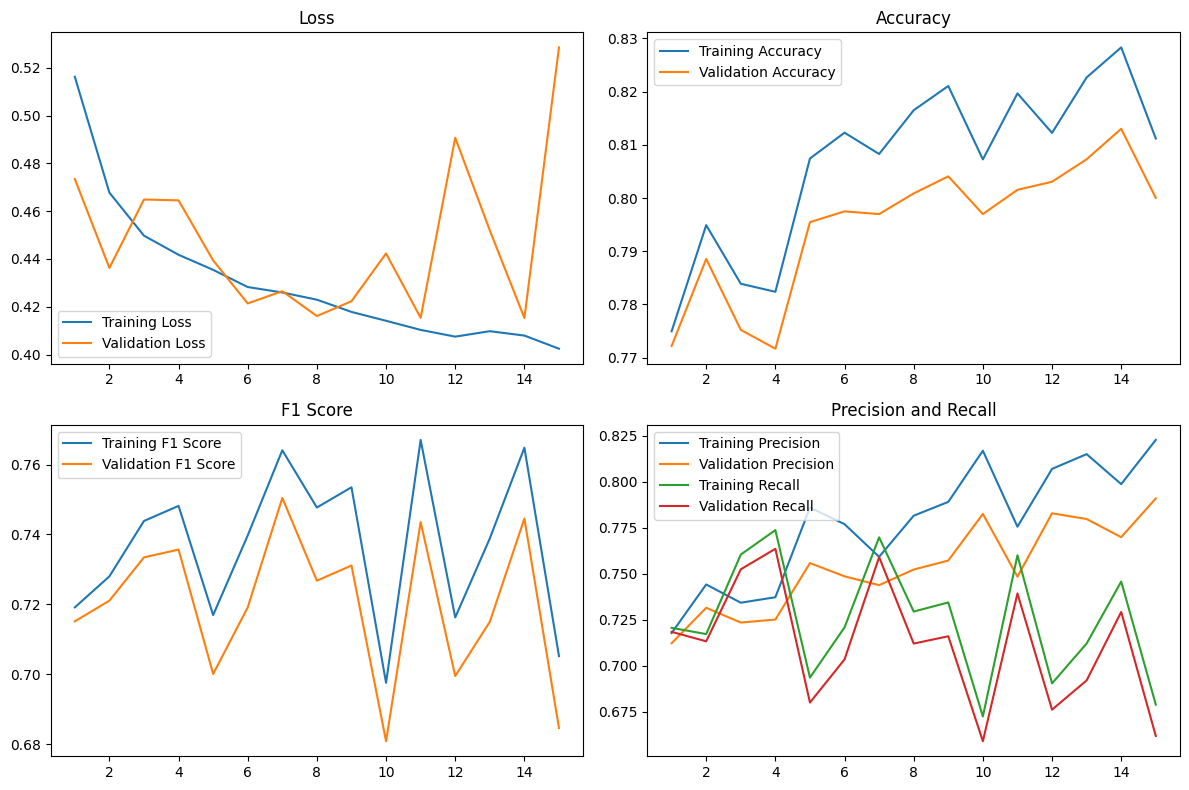

In [13]:
#Assuming model has already been defined and instantiated
model = EvidenceDetectionModel(num_hiddens=100, ffn_num_hiddens=256, num_heads=4,
                               num_blks=2, dropout=0.1, num_classes=2)

def plot_metrics(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history["train_loss"], label='Training Loss')
    plt.plot(epochs, history["val_loss"], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, history["train_accuracy"], label='Training Accuracy')
    plt.plot(epochs, history["val_accuracy"], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, history["train_f1"], label='Training F1 Score')
    plt.plot(epochs, history["val_f1"], label='Validation F1 Score')
    plt.title('F1 Score')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, history["train_precision"], label='Training Precision')
    plt.plot(epochs, history["val_precision"], label='Validation Precision')
    plt.plot(epochs, history["train_recall"], label='Training Recall')
    plt.plot(epochs, history["val_recall"], label='Validation Recall')
    plt.title('Precision and Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

#Setup optimizer and loss function
class DeltaGClipOptimizer(Optimizer):
    def __init__(self, params, lr=0.1, delta=1e-03, gamma=0.25):
        defaults = dict(lr=lr, delta=delta, gamma=gamma)
        super(DeltaGClipOptimizer, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        for group in self.param_groups:
            delta = group['delta']
            gamma = group['gamma']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                norm = grad.norm()
                if norm != 0 and not torch.isnan(norm):
                    g_norm = min(1, max(delta, gamma / norm))
                    scaled_grad = g_norm * grad
                    p.data -= lr * scaled_grad

optimizer = DeltaGClipOptimizer(model.parameters(), lr=0.05, delta=1e-03, gamma=0.25)
loss_fn = CrossEntropyLoss()

#Define the training step
def train_step(model, data_loader, optimizer, loss_fn, device):
    model.train() #Set model to train mode
    total_loss = 0
    for embeddings, labels in data_loader:
        #Iterates over each
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(embeddings)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def validate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for embeddings, labels in data_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            logits = model(embeddings)
            loss = loss_fn(logits, labels)
            predictions = torch.argmax(logits, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()

    metrics = compute_metrics(all_predictions, all_labels)
    return total_loss / len(data_loader), metrics

#Main training function
def train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, epochs, device):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "train_precision": [],
        "train_recall": [],
        "train_f1": [],
        "val_accuracy": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": []
    }

    for epoch in range(epochs):
        #Training
        model.train()
        train_losses = []
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(embeddings)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        train_loss_avg = sum(train_losses) / len(train_losses)
        train_metrics = evaluate_predictions(model, train_loader, device)
        history["train_loss"].append(train_loss_avg)
        history["train_accuracy"].append(train_metrics[0])
        history["train_precision"].append(train_metrics[1])
        history["train_recall"].append(train_metrics[2])
        history["train_f1"].append(train_metrics[3])

        #Validation
        val_loss_avg, val_metrics = validate(model, val_loader, loss_fn, device)
        history["val_loss"].append(val_loss_avg)
        history["val_accuracy"].append(val_metrics[0])
        history["val_precision"].append(val_metrics[1])
        history["val_recall"].append(val_metrics[2])
        history["val_f1"].append(val_metrics[3])

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}')

        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
        print(f'Model saved for epoch {epoch+1}')
    plot_metrics(history)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#Call to the training function
train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, epochs=15, device=device)
